# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [21]:
# import libraries here; add more as necessary
from pprint import pprint 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from xgboost import XGBRFClassifier

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', None)
# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

# load in the data
azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

In [2]:
azdias = pd.read_csv('Udacity_AZDIAS_052018.csv', low_memory=False)
customers = pd.read_csv('Udacity_CUSTOMERS_052018.csv', low_memory=False)

First lets check the general information about the `azdias` and `customer` dataframes

In [3]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Columns: 367 entries, Unnamed: 0 to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(94), object(6)
memory usage: 2.4+ GB


In [4]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191652 entries, 0 to 191651
Columns: 370 entries, Unnamed: 0 to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(95), object(8)
memory usage: 541.0+ MB


In [5]:
customers.head(3)

,Unnamed: 0,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4


In [6]:
azdias.head(3)

,Unnamed: 0,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3


Lets drop the `Unnamed: 0` column from each of the dataframes as thats just a redundant column produced from `read_csv`.

In [7]:
azdias.drop(columns=['Unnamed: 0'],inplace=True)
customers.drop(columns=['Unnamed: 0'],inplace=True)

## Exploring attributes of the data

In this section the `attributes_values` and `attributes_info` will be created and cleansed. Each of these dataframes provide information about the features and the meaning of the input values.

* `attribute_values`: Provides a description of the columns within the `customers` and `azdias` dataframes. Information is also provided about the values each column contains.
* `attribute_info`: Contains more detailed information about each column with additional notes in some instances.

In [22]:
attributes_values = pd.read_excel('DIAS Attributes - Values 2017.xlsx', header=1)
attributes_info = pd.read_excel('DIAS Information Levels - Attributes 2017.xlsx', header=1) 

In [23]:
attributes_values.head(10)

,Unnamed: 0,Attribute,Description,Value,Meaning
0,NaN,AGER_TYP,best-ager typology,-1,unknown
1,NaN,NaN,NaN,0,no classification possible
2,NaN,NaN,NaN,1,passive elderly
3,NaN,NaN,NaN,2,cultural elderly
4,NaN,NaN,NaN,3,experience-driven elderly
5,NaN,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
6,NaN,NaN,NaN,1,< 30 years
7,NaN,NaN,NaN,2,30 - 45 years
8,NaN,NaN,NaN,3,46 - 60 years
9,NaN,NaN,NaN,4,> 60 years


It looks like the `Unnamed: 0` needs to be dropped again. Furthermore, the `Attribute` and `Description` values are missing a lot of values. It looks like the most recent entry is the most likely candidate to fill the nan values so the `ffill` method will be used to fill the nan values for `Attribute` and `Description`.

In [24]:
attributes_values.drop(columns=['Unnamed: 0'],inplace=True)
attributes_values["Attribute"] = attributes_values["Attribute"].ffill()
attributes_values["Description"] = attributes_values["Description"].ffill()
attributes_values.head(10) #Check if all is well

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,AGER_TYP,best-ager typology,0,no classification possible
2,AGER_TYP,best-ager typology,1,passive elderly
3,AGER_TYP,best-ager typology,2,cultural elderly
4,AGER_TYP,best-ager typology,3,experience-driven elderly
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
6,ALTERSKATEGORIE_GROB,age classification through prename analysis,1,< 30 years
7,ALTERSKATEGORIE_GROB,age classification through prename analysis,2,30 - 45 years
8,ALTERSKATEGORIE_GROB,age classification through prename analysis,3,46 - 60 years
9,ALTERSKATEGORIE_GROB,age classification through prename analysis,4,> 60 years


The __Attributes__ and __Description__ columns in the `attributes_values` dataframe have NaN values and it is easy to understand that the most recent entry is representative of each NaN value in each of the columns. The pandas function `ffill` will be used to fill the NaN values in the aforementioned columns to enable easy access to all the attribute and descriptions in a single attempt

In [25]:
attributes_values[['Attribute','Description']] = attributes_values[['Attribute','Description']].ffill()
attributes_values.head()

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,AGER_TYP,best-ager typology,0,no classification possible
2,AGER_TYP,best-ager typology,1,passive elderly
3,AGER_TYP,best-ager typology,2,cultural elderly
4,AGER_TYP,best-ager typology,3,experience-driven elderly


There are some values which have an unknown meaning. Therefore it probably best to replace these values with NaN. But this will be dealt with in the data celaning section.

### Cleaning attribute info

In [26]:
attributes_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 313 entries, 0 to 312
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         0 non-null      float64
 1   Information level  10 non-null     object 
 2   Attribute          313 non-null    object 
 3   Description        313 non-null    object 
 4   Additional notes   20 non-null     object 
dtypes: float64(1), object(4)
memory usage: 12.4+ KB


In [27]:
attributes_info.head(15)

,Unnamed: 0,Information level,Attribute,Description,Additional notes
0,NaN,NaN,AGER_TYP,best-ager typology,in cooperation with Kantar TNS; the information basis is a consumer survey
1,NaN,Person,ALTERSKATEGORIE_GROB,age through prename analysis,modelled on millions of first name-age-reference data
2,NaN,NaN,ANREDE_KZ,gender,NaN
3,NaN,NaN,CJT_GESAMTTYP,Customer-Journey-Typology relating to the preferred information and buying channels of consumers,"relating to the preferred information, marketing and buying channels of consumers as well as their cross-channel usage. The information basis is a survey on the consumer channel preferences combined via a statistical modell with AZ DIAS data"
4,NaN,NaN,FINANZ_MINIMALIST,financial typology: low financial interest,Gfk-Typology based on a representative household panel combined via a statistical modell with AZ DIAS data
5,NaN,NaN,FINANZ_SPARER,financial typology: money saver,NaN
6,NaN,NaN,FINANZ_VORSORGER,financial typology: be prepared,NaN
7,NaN,NaN,FINANZ_ANLEGER,financial typology: investor,NaN
8,NaN,NaN,FINANZ_UNAUFFAELLIGER,financial typology: unremarkable,NaN
9,NaN,NaN,FINANZ_HAUSBAUER,financial typology: main focus is the own house,NaN


For all intents and purposes the `Information level` is unnecessary for further analysis and yet again the ` 	Unnamed: 0` can go as well.

In [28]:
attributes_info.drop(columns=['Unnamed: 0','Information level'],inplace=True)

## Data cleansing

From the `attributes_values` dataframe there were a few values which had unknown values. It is best to replace these values with nan. First though we should check the format these unknown values come in

In [29]:
attributes_values[attributes_values.Meaning == 'unknown'][['Attribute','Value']].head()

,Attribute,Value
0,AGER_TYP,-1
5,ALTERSKATEGORIE_GROB,"-1, 0"
33,ANREDE_KZ,"-1, 0"
40,BALLRAUM,-1
48,BIP_FLAG,-1


In [30]:
attributes_values[attributes_values.Meaning == 'unknown'][['Attribute','Value']].Value.unique()

array([-1, '-1, 0', 0, '-1, 9', '-1'], dtype=object)

All integer values in the unknown so no need for special cases for floats. However there are strings so these will be handled by splitting them at the comma and converting the resulting array into an integer

In [31]:
def get_unknown_vals(attrib, unknown_attrib_vals= \
                    attributes_values[attributes_values.Meaning == 'unknown'][['Attribute','Value']]):
    """Returns a list of unknown values for a given attribute unknown values
    Input
    attrib: An value which should be present in the Attribute column of the unknown_attrib_vals dataframe
    unknown_attrib_vals: A dataframe which should be filtered for all the rows of the attribute_values 
    dataframe which contain an "unknown" in the Meaning column. It is the desired dataframe for this 
    notebook by default.
    
    Output:
    An array of values which correspond to unknown meanings for a given attribute
    """
    
    unknown = unknown_attrib_vals[unknown_attrib_vals["Attribute"] == attrib]["Value"]
    #Some values have a commas which means multiple unknown values. Therefore separate y=by comma and convert
    #to int as non of the values have floats
    unknown = unknown.astype(str).str.cat(sep=",")
    #unknown = [int(x) for x in unknown.split(",")]
    unknown_arr = []
    for i in unknown.split(","):
        try:
            unknown_arr.append(int(i))
        except:
            unknown_arr.append(i)
        
    
    #Output needs to be an array so that it is iterable so it can be passed as unknown with _replace_with_nan 
    return [unknown_arr] 

def _replace_with_nan(val, unknown):
    """Helper function to replaces unknown values with np.nan if the value matches with the 
    unknown representation
    Input
    val: Should just be an integer, string or float
    unknown: An array which corresponds to values of unknown meaning
    
    Output:
    np.nan if val is equal to a value of unknown meaning otherwise just the input val unchanged.
    """
    if val in unknown:
        return np.nan
    else:
        return val
    

def replace_unknowns(df, unknown_attrib_vals= \
                    attributes_values[attributes_values.Meaning == 'unknown'][['Attribute','Value']]):
    """
    Replaces values in df with an unknown meaning (as specified by `unknown_attrib_vals`) with np.nan
    Input
    df: df to replace values with unknown meaning with np.nan
    unknown_attrib_vals:A dataframe which should be filtered for all the rows of the attribute_values 
    dataframe which contain an "unknown" in the Meaning column. It is the desired dataframe for this 
    notebook by default.
    
    Output=df: A datagrame with all values with unknown meaning replaced
    """
    for attrib in unknown_attrib_vals.Attribute:
        unknowns = get_unknown_vals(attrib)
        if attrib in df.columns:
            df[attrib] = df[attrib].apply(_replace_with_nan, args=(unknowns))
    return df

In [18]:
ager_typ_unknown = get_unknown_vals("AGER_TYP")
ager_typ_unknown

[[-1]]

In [19]:
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


In [20]:
ager_typ_unknown = customers.AGER_TYP.apply(_replace_with_nan, args=(ager_typ_unknown))

In [21]:
replace_unknowns(azdias)
replace_unknowns(customers)

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2.0,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,NaN,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,NaN,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,NaN,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1.0,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,NaN,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191647,154561,1.0,1.0,9.0,NaN,NaN,NaN,NaN,9.0,1.0,...,5.0,6.0,9.0,1.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,3
191648,154563,NaN,2.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,...,4.0,NaN,9.0,3.0,3,COSMETIC,SINGLE_BUYER,0,2,4
191649,148813,2.0,1.0,15.0,NaN,NaN,NaN,NaN,10.0,1.0,...,5.0,3.0,9.0,3.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
191650,148852,3.0,1.0,13.0,NaN,NaN,NaN,NaN,13.0,4.0,...,1.0,4.0,9.0,2.0,3,FOOD,SINGLE_BUYER,0,2,3


Looks like it works

## Further analysing the categorical data

Some of the categorical data may require special treatment so it's best to check out the categories and values for each of them for both of the categories.

In [32]:
def get_unique_cats(df):
    """
    Prints out the unqiue values for each object column in the pandas dataframe 'df'
    """
    unique_dict = {}
    cols = df.select_dtypes(include=['object'])
    for col in cols:
        unique_vals = df[col].unique()
        #unique_dict[col] = list(df[col].unique())
        #pprint(unique_dict) pprint is too long
        print('{}:{}'.format(col,unique_vals))

In [11]:
get_unique_cats(customers)

CAMEO_DEU_2015:['1A' nan '5D' '4C' '7B' '3B' '1D' '9E' '2D' '4A' '6B' '9D' '8B' '5C' '9C'
 '4E' '6C' '8C' '8A' '5B' '9B' '3D' '2A' '3C' '5F' '7A' '1E' '2C' '7C'
 '5A' '2B' '6D' '7E' '5E' '6E' '3A' '9A' '4B' '1C' '1B' '6A' '8D' '7D'
 '6F' '4D' 'XX']
CAMEO_DEUG_2015:['1.0' nan '5.0' '4.0' '7.0' '3.0' '9.0' '2.0' '6.0' '8.0' '6' '3' '8' '9'
 '2' '4' '1' '7' '5' 'X']
CAMEO_INTL_2015:['13.0' nan '34.0' '24.0' '41.0' '23.0' '15.0' '55.0' '14.0' '22.0' '43.0'
 '51.0' '33.0' '25.0' '44.0' '54.0' '32.0' '12.0' '35.0' '31.0' '45.0'
 '52.0' '45' '25' '55' '51' '14' '54' '43' '22' '15' '24' '35' '23' '12'
 '44' '41' '52' '31' '13' '34' '32' '33' 'XX']
D19_LETZTER_KAUF_BRANCHE:['D19_UNBEKANNT' 'D19_BANKEN_GROSS' 'D19_NAHRUNGSERGAENZUNG' 'D19_SCHUHE'
 'D19_BUCH_CD' 'D19_DROGERIEARTIKEL' 'D19_SONSTIGE' 'D19_TECHNIK'
 'D19_VERSICHERUNGEN' 'D19_TELKO_MOBILE' 'D19_VOLLSORTIMENT' nan
 'D19_HAUS_DEKO' 'D19_ENERGIE' 'D19_REISEN' 'D19_BANKEN_LOKAL'
 'D19_VERSAND_REST' 'D19_BEKLEIDUNG_REST' 'D19_FREIZEIT'
 '

In [24]:
get_unique_cats(azdias)

CAMEO_DEU_2015:[nan '8A' '4C' '2A' '6B' '8C' '4A' '2D' '1A' '1E' '9D' '5C' '8B' '7A' '5D'
 '9E' '9B' '1B' '3D' '4E' '4B' '3C' '5A' '7B' '9A' '6D' '6E' '2C' '7C'
 '9C' '7D' '5E' '1D' '8D' '6C' '6A' '5B' '4D' '3A' '2B' '7E' '3B' '6F'
 '5F' '1C' 'XX']
CAMEO_DEUG_2015:[nan '8.0' '4.0' '2.0' '6.0' '1.0' '9.0' '5.0' '7.0' '3.0' '4' '3' '7' '2'
 '8' '9' '6' '5' '1' 'X']
CAMEO_INTL_2015:[nan '51.0' '24.0' '12.0' '43.0' '54.0' '22.0' '14.0' '13.0' '15.0' '33.0'
 '41.0' '34.0' '55.0' '25.0' '23.0' '31.0' '52.0' '35.0' '45.0' '44.0'
 '32.0' '22' '24' '41' '12' '54' '51' '44' '35' '23' '25' '14' '34' '52'
 '55' '31' '32' '15' '13' '43' '33' '45' 'XX']
D19_LETZTER_KAUF_BRANCHE:[nan 'D19_UNBEKANNT' 'D19_SCHUHE' 'D19_ENERGIE' 'D19_KOSMETIK'
 'D19_VOLLSORTIMENT' 'D19_SONSTIGE' 'D19_BANKEN_GROSS'
 'D19_DROGERIEARTIKEL' 'D19_HANDWERK' 'D19_BUCH_CD' 'D19_VERSICHERUNGEN'
 'D19_VERSAND_REST' 'D19_TELKO_REST' 'D19_BANKEN_DIREKT' 'D19_BANKEN_REST'
 'D19_FREIZEIT' 'D19_LEBENSMITTEL' 'D19_HAUS_DEKO' 'D19_BEKLE

For starters both the `CAMEO_DEUG_2015`, `CAMEO_DEU_2015` and `CAMEO_INTL_2015` columns have 'X' or 'XX' values which should be replaced with nan values and the `CAMEO_INTL_2015` and `CAMEO_DEUG_2015` need to be standardised into integers as well.

First it's best to create a function which converts a string of a float into an integer and handles a string of an integer and np.nan values unaffected 

In [33]:
def obj2numstr(x):
    """Turn an object of numbers of floats, strings and integers be converted 
    into a numerical integer string. Let np.nan be unchanged"""
    if pd.notna(x):
        return str(x).split('.')[0]
    else: return x

In [26]:
#Tests
assert obj2numstr(2) == '2'
assert obj2numstr(12.0) == '12'
assert obj2numstr('13.43') == '13'
assert pd.isna(obj2numstr(np.nan))
print('It works')

It works


In [27]:
azdias['CAMEO_INTL_2015'] = azdias.CAMEO_INTL_2015.replace(to_replace='XX',value=np.nan).apply(obj2numstr)
azdias['CAMEO_DEUG_2015'] = azdias.CAMEO_DEUG_2015.replace(to_replace='X',value=np.nan).apply(obj2numstr)
azdias['CAMEO_DEU_2015'] = azdias.CAMEO_DEU_2015.replace(to_replace='XX',value=np.nan)

In [28]:
customers['CAMEO_INTL_2015'] = customers.CAMEO_INTL_2015.replace(to_replace='XX',value=np.nan).apply(obj2numstr)
customers['CAMEO_DEUG_2015'] = customers.CAMEO_DEUG_2015.replace(to_replace='X',value=np.nan).apply(obj2numstr)
customers['CAMEO_DEU_2015'] = customers.CAMEO_DEU_2015.replace(to_replace='XX',value=np.nan)

In [29]:
get_unique_cats(azdias)
print('='*50)
get_unique_cats(customers)

CAMEO_DEU_2015:[nan '8A' '4C' '2A' '6B' '8C' '4A' '2D' '1A' '1E' '9D' '5C' '8B' '7A' '5D'
 '9E' '9B' '1B' '3D' '4E' '4B' '3C' '5A' '7B' '9A' '6D' '6E' '2C' '7C'
 '9C' '7D' '5E' '1D' '8D' '6C' '6A' '5B' '4D' '3A' '2B' '7E' '3B' '6F'
 '5F' '1C']
CAMEO_DEUG_2015:[nan '8' '4' '2' '6' '1' '9' '5' '7' '3']
CAMEO_INTL_2015:[nan '51' '24' '12' '43' '54' '22' '14' '13' '15' '33' '41' '34' '55' '25'
 '23' '31' '52' '35' '45' '44' '32']
D19_LETZTER_KAUF_BRANCHE:[nan 'D19_UNBEKANNT' 'D19_SCHUHE' 'D19_ENERGIE' 'D19_KOSMETIK'
 'D19_VOLLSORTIMENT' 'D19_SONSTIGE' 'D19_BANKEN_GROSS'
 'D19_DROGERIEARTIKEL' 'D19_HANDWERK' 'D19_BUCH_CD' 'D19_VERSICHERUNGEN'
 'D19_VERSAND_REST' 'D19_TELKO_REST' 'D19_BANKEN_DIREKT' 'D19_BANKEN_REST'
 'D19_FREIZEIT' 'D19_LEBENSMITTEL' 'D19_HAUS_DEKO' 'D19_BEKLEIDUNG_REST'
 'D19_SAMMELARTIKEL' 'D19_TELKO_MOBILE' 'D19_REISEN' 'D19_BEKLEIDUNG_GEH'
 'D19_TECHNIK' 'D19_NAHRUNGSERGAENZUNG' 'D19_DIGIT_SERV' 'D19_LOTTO'
 'D19_RATGEBER' 'D19_TIERARTIKEL' 'D19_KINDERARTIKEL' 'D19_BIO_

Looks like it worked. Lets save the the results of some of our dataframes

## Removing rows and columns with too many missing values

There are some columns and rows which have too many nan values that it becomes difficult to derive value off of them. Subsequently it makes sense that these rows and columns should be removed to prevent speculative data based off of imputing poisoning the machine learning models produced from them. 

The generic strategy will be to select a cutoff point where most of the data can be maintained. 

In [30]:
len(azdias)

891221

In [31]:
len(customers)

191652

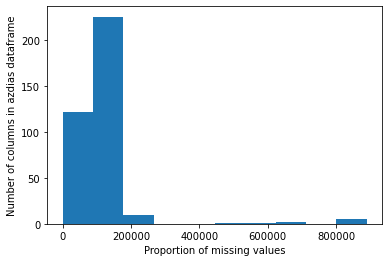

In [32]:
plt.hist(azdias.isna().sum())
plt.xlabel('Proportion of missing values');
plt.ylabel('Number of columns in azdias dataframe');

From the above it is clear that any columns with more than 30% of the missing values should be dropped. Therefore this will be the criteria for dropping columns

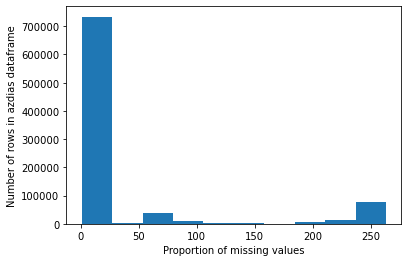

In [33]:
plt.hist(azdias.isna().sum(axis=1))
plt.xlabel('Proportion of missing values');
plt.ylabel('Number of rows in azdias dataframe');

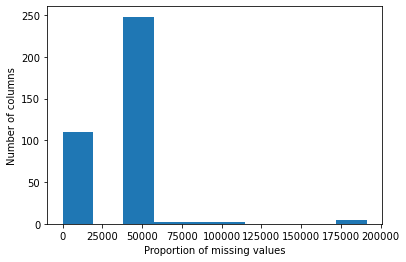

In [34]:
plt.hist(customers.isna().sum());
plt.xlabel('Proportion of missing values');
plt.ylabel('Number of columns');

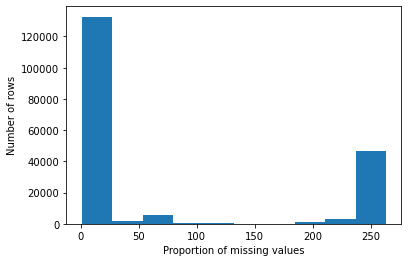

In [35]:
plt.hist(customers.isna().sum(axis=1));
plt.xlabel('Proportion of missing values');
plt.ylabel('Number of rows');

From the plot above it is clear that most of the rows are filled. A good cutoff point appears to around 0.45. This is because this captures most of the dataset. 

In [34]:
def drop_cols_rows(df,row_thresh,col_thresh):
    """
    returns a dataframe with rows and columns dropped which exceeds a threshold of nan values whom proportions 
    exceed row_perc (to drop rows) or col_perc (to drop columns)
    """
    num_cols = len(df.columns)
    num_rows = len(df)
    dropped_df_cols =  df.dropna(axis=1,thresh=num_rows-col_thresh)
    dropped_df = dropped_df_cols.dropna(axis=0,thresh=num_cols-row_thresh)
    return dropped_df
    

In [37]:
customers_dropped = drop_cols_rows(customers,50,60_000)

In [38]:
azdias_dropped = drop_cols_rows(azdias,50,300_000)

Text(0, 0.5, 'Number of rows')

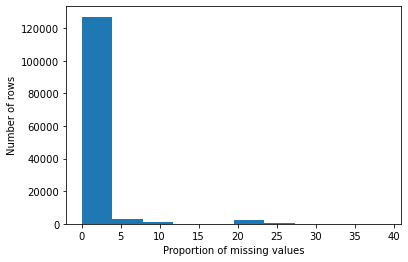

In [39]:
plt.hist(customers_dropped.isna().sum(axis=1))
plt.xlabel('Proportion of missing values')
plt.ylabel('Number of rows')

Text(0, 0.5, 'Number of columns')

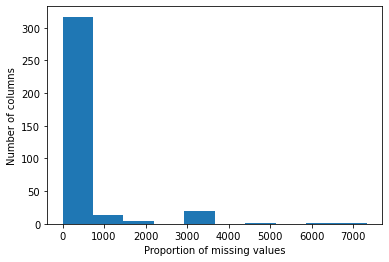

In [40]:
plt.hist(customers_dropped.isna().sum(axis=0))
plt.xlabel('Proportion of missing values')
plt.ylabel('Number of columns')

In [41]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191652 entries, 0 to 191651
Columns: 369 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(273), int64(88), object(8)
memory usage: 539.5+ MB


### Exploring attribute values and their meaning

In [42]:
attribute_values = pd.read_excel('DIAS Attributes - Values 2017.xlsx')
attribute_values.head()

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,NaN,Attribute,Description,Value,Meaning
1,NaN,AGER_TYP,best-ager typology,-1,unknown
2,NaN,NaN,NaN,0,no classification possible
3,NaN,NaN,NaN,1,passive elderly
4,NaN,NaN,NaN,2,cultural elderly


Lets put all the transformation inthis section together and create a function which puts them all together.

In [35]:
def clean_df(df_path,row_thresh,col_thresh,path=True,drop=True):
    """
    Cleans a dataframe and then drops rows where the number of missing values along a row
    exceed row_thresh and drops columns where the number of missing values in a column exceed col_thresh.
    Input
    df_path: Can be the dataframe if path=False, otherwise it must be a math to a csv file. 
    This is the dataa which is expected to be cleaned.
    row_thresh: Threshold for number of nan values along a row (This is a number not a proportion). If the
    number of nan values is greater than this the row will be dropped.
    col_thresh: Threshold for number of nan values along a column (This is a number not a proportion). If the
    number of nan values is greater than this the column will be dropped.
    path: A boolean value. If True then df_path must be a string which is a path to a csv file. Otherwise
    it should be a dataframe.
    drop: If true rows and columns will be dropped otherwise no columns or rows will be dropped.
    """
    df = df_path
    if path == True:
        df = pd.read_csv(df_path)
    
    #drop the Unnamed: 0 column if its in there
    if 'Unnamed: 0' in df.columns: df.drop(columns=['Unnamed: 0'],inplace=True)
    #Drop time series data
    if 'EINGEFUEGT_AM' in df.columns: df.drop(columns=['EINGEFUEGT_AM'],inplace=True)
    #Replace values of meaning with np.nan
    
    df = replace_unknowns(df)
    
    #Clean up categorical data
    if 'CAMEO_INTL_2015' in df.columns:
        df['CAMEO_INTL_2015'] = df.CAMEO_INTL_2015.replace(to_replace='XX',value=np.nan).apply(obj2numstr)
    if 'CAMEO_DEUG_2015' in df.columns:
        df['CAMEO_DEUG_2015'] = df.CAMEO_DEUG_2015.replace(to_replace='X',value=np.nan).apply(obj2numstr)
    if 'CAMEO_DEU_2015' in df.columns:
        df['CAMEO_DEU_2015'] = df.CAMEO_DEU_2015.replace(to_replace='XX',value=np.nan)
    
    #The line below is a test
    #get_unique_cats(df)
    
    #drop columns and rows with too many nan values
    if drop==True:
        df =  drop_cols_rows(df,row_thresh,col_thresh)
    df_cols = df.columns
    #And finally it's time to scale the data and replace the nan values using a pipeline
    
    cat_cols = df.select_dtypes(include=['object']).columns
    int_cols = df.select_dtypes(include=['int']).columns
    float_cols = df.select_dtypes(include=['float']).columns
    
    [df[col].fillna(value=df[col].mean(),inplace=True) for col in float_cols]

    [df[col].fillna(value=df[col].mode().iloc[0],inplace=True) for col in int_cols]

    [df[col].fillna(value=df[col].mode().iloc[0],inplace=True) for col in cat_cols]
        
    
    cat_transformer = ColumnTransformer(transformers=[
        ('cat_trans',OrdinalEncoder(),cat_cols),
    ],remainder='passthrough')
    
    return pd.DataFrame(data=cat_transformer.fit_transform(df),columns=df_cols)
    
    

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

## Dimensionality reduction

There is a large number of features in each of the datasets. It is likely that there is a lot of _*_. By using dimensionality reduction it will be possible to remove features which do not affect the variability of the data. PCA will be used for dimensionality reduction. 

But first it's best to create a pipeline to deal with all the missing values and scaling all the data before further analysis is done 

In [16]:
azdias_p1 = clean_df('Udacity_AZDIAS_052018.csv',50,300_000,path=True,drop=True)
customers_p1 = clean_df('Udacity_CUSTOMERS_052018.csv',50,60_000,path=True,drop=True)
attrib_info = pd.read_excel('DIAS Information Levels - Attributes 2017.xlsx',header=1)

In [36]:
def create_pipeline(model):
    """Creates a pipeline for training a model. Only transformation is the MinMaxScaler"""
    return Pipeline(steps=[
    ('scaler',MinMaxScaler()),
    ('model',model)
])

As both the customers and azdias dataframes both have columns that are dropped which are not the same, it's best to identify the columns that are in both dataframes so that comparisons can be made.

In [22]:
distinct_cols = np.intersect1d(azdias_p1.columns,customers_p1.columns)
azdias_p1 = azdias_p1[distinct_cols]
customers_p1 = customers_p1[distinct_cols]

In [23]:
customers_p1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134246 entries, 0 to 134245
Columns: 354 entries, AKT_DAT_KL to ZABEOTYP
dtypes: float64(354)
memory usage: 362.6 MB


Lets check out what the most important features are using PCA. Since this .............................................................

In [26]:
def plot_pca_exp_variance(data, n_comps=None,):
    """
    Plots a normalised plot of the cumulative sum of the explained variance ratio for each 
    component number of components used in the PCA analysis. 
    
    Input
    data: Data to perform PCA on
    n_comps: Number of components to perform PCA analysis on. If et to None all components will be used.
    """   
    pca = create_pipeline(PCA())
    pca.fit_transform(data)
    
    azdias_variance = np.cumsum(pca['model'].explained_variance_ratio_)
    y_label = "Percentage  of the explained variance"

    fig = plt.figure(figsize = (10,8))

    ax = fig.add_subplot(212)
    ax.plot(azdias_variance)
    ax.set_xlabel("Number of components")
    ax.set_ylabel(y_label)
    ax.set_title("PCA Explained Variance Ratio vs Number of Components \n General population")
    ax.grid()
    plt.show()
    

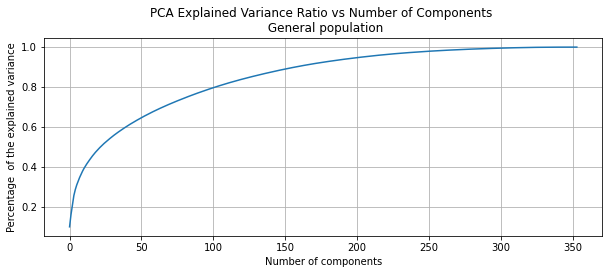

In [27]:
plot_pca_exp_variance(azdias_p1)

Now lets take a closer look at what attributes are the most important

In [35]:
def plot_feature_weights(df, pca, dims, n_weights = 5,attrib_info=attributes_info):
    """
    This function displays interesting features of the selected dims
    """
    
    features = df.columns.values
    components = pca['model'].components_
    feature_weights = dict(zip(features, components[dims]))
    sorted_weights = sorted(feature_weights.items(), key = lambda kv: kv[1])
    
    feat_names = []
    feat_weights = []
    feat_descs = []

    for feature, weight in sorted_weights[-n_weights:]:
        feat_names.append(feature)
        feat_weights.append(weight)
        
    for feature, weight, in sorted_weights[:n_weights]:
        feat_names.append(feature)
        feat_weights.append(weight)
        
    for feature in feat_names:
        if feature in attrib_info.Attribute.values:
            feat_descs.append(attrib_info[attrib_info.Attribute == feature].Description.values[0])
        else:
            feat_descs.append("Unknown description")
    
    component_info = {"Feature":feat_names, "Description":feat_descs, "FeatureWeight":feat_weights}
    component_info = pd.DataFrame(component_info)
    component_info.sort_values("FeatureWeight", inplace=True, ascending=False, ignore_index=True)
    
    #Start plotting
    fig = plt.figure(figsize=(10,16))

    ax = fig.add_subplot(211)
    ax.bar(feat_names, feat_weights)
    ax.set_ylabel("Feature Weight")
    ax.set_xlabel("Feature Name")
    ax.set_title("PCA Feature weights - Component {}".format(dims+1))
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)


    fig.tight_layout()
    plt.show()
    
    return component_info

In [31]:
pca_p1 = create_pipeline(PCA(n_components=100))
pca_p1.fit(azdias_p1)

Pipeline(steps=[('scaler', MinMaxScaler()), ('model', PCA(n_components=100))])

In [34]:
pca_p1['model'].components_

array([[-0.12637021, -0.04790383,  0.01447854, ...,  0.03241779,
        -0.05817446, -0.07680249],
       [ 0.02507082, -0.06458598, -0.06158126, ..., -0.0028074 ,
        -0.12494995,  0.0365522 ],
       [-0.03386693, -0.00636117, -0.0035462 , ..., -0.07340715,
         0.00468949, -0.01549096],
       ...,
       [ 0.00834725, -0.03352171, -0.00411445, ..., -0.01212125,
        -0.08862661,  0.0168384 ],
       [-0.03195484, -0.01448906, -0.00568972, ..., -0.01036437,
         0.02866249,  0.01382883],
       [-0.01304233, -0.25430213, -0.01146207, ...,  0.08147134,
        -0.02150784,  0.0360951 ]])

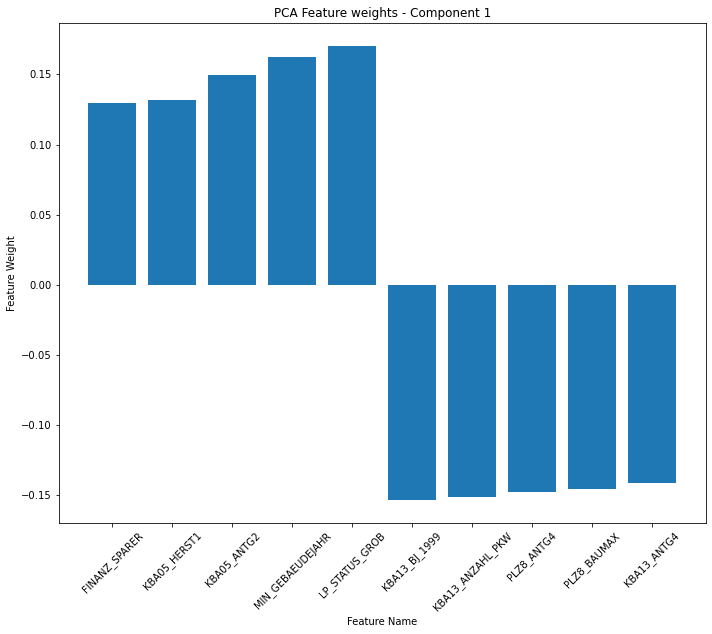

,Feature,Description,FeatureWeight
0,LP_STATUS_GROB,social status rough,0.170327
1,MIN_GEBAEUDEJAHR,year the building was first mentioned in our database,0.162733
2,KBA05_ANTG2,number of 3-5 family houses in the cell,0.149373
3,KBA05_HERST1,"share of top German manufacturer (Mercedes, BMW)",0.131591
4,FINANZ_SPARER,financial typology: money saver,0.129627
5,KBA13_ANTG4,Unknown description,-0.141560
6,PLZ8_BAUMAX,most common building-type within the PLZ8,-0.145825
7,PLZ8_ANTG4,number of >10 family houses in the PLZ8,-0.147356
8,KBA13_ANZAHL_PKW,number of cars in the PLZ8,-0.150875
9,KBA13_BJ_1999,share of cars built between 1995 and 1999 within the PLZ8,-0.153552


In [36]:
plot_feature_weights(azdias_p1,pca_p1,dims=0)

it looks like the most important feature in the data set is whether someone's social status is rough. However the remainder of the top features from component 1 looks be a mixed bag with only the feature `FINANZ_SPARER` complementing the financial situation theme of the most important feature `LP_STATUS_GROB`.

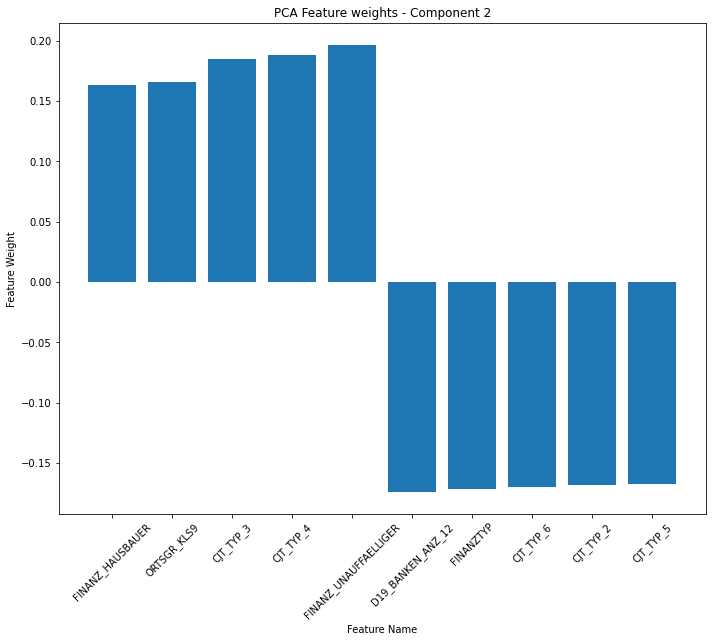

,Feature,Description,FeatureWeight
0,FINANZ_UNAUFFAELLIGER,financial typology: unremarkable,0.196367
1,CJT_TYP_4,Unknown description,0.187735
2,CJT_TYP_3,Unknown description,0.184595
3,ORTSGR_KLS9,classified number of inhabitants,0.165922
4,FINANZ_HAUSBAUER,financial typology: main focus is the own house,0.163052
5,CJT_TYP_5,Unknown description,-0.167172
6,CJT_TYP_2,Unknown description,-0.168092
7,CJT_TYP_6,Unknown description,-0.169709
8,FINANZTYP,best descirbing financial type for the peron,-0.171636
9,D19_BANKEN_ANZ_12,Unknown description,-0.174026


In [38]:
plot_feature_weights(azdias_p1,pca_p1,dims=1)

It looks like the most important feature for the second component is the financial topology with features assocaited with CJT also making a dominating a lot of the most important features in this component. 

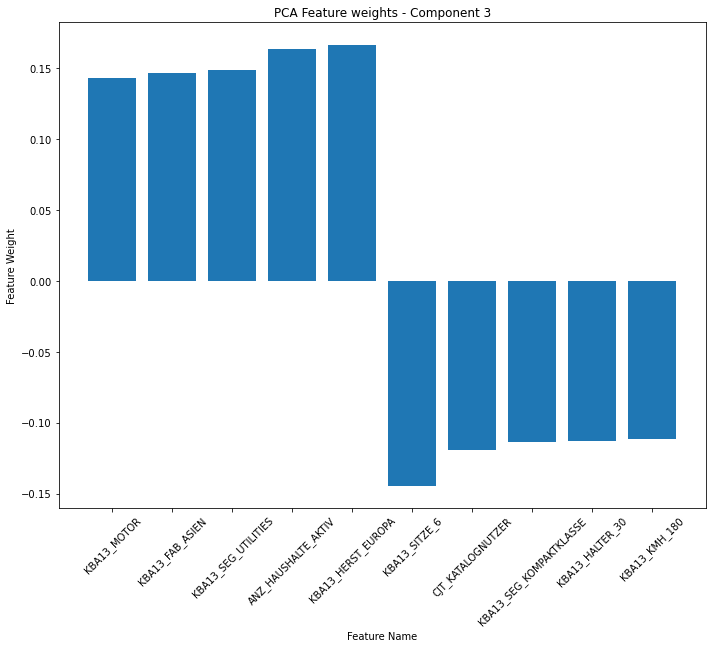

,Feature,Description,FeatureWeight
0,KBA13_HERST_EUROPA,share of European cars within the PLZ8,0.166467
1,ANZ_HAUSHALTE_AKTIV,number of households known in this building,0.163659
2,KBA13_SEG_UTILITIES,share of MUVs/SUVs within the PLZ8,0.148223
3,KBA13_FAB_ASIEN,share of other Asian Manufacturers within the PLZ8,0.146112
4,KBA13_MOTOR,most common motor size within the PLZ8,0.143080
5,KBA13_KMH_180,share of cars with max speed between 110 km/h and 180km/h within the PLZ8,-0.111630
6,KBA13_HALTER_30,share of car owners between 26 and 30 within the PLZ8,-0.112925
7,KBA13_SEG_KOMPAKTKLASSE,share of lowe midclass cars (Ford Focus etc.) in the PLZ8,-0.113594
8,CJT_KATALOGNUTZER,Unknown description,-0.118952
9,KBA13_SITZE_6,number of cars with more than 5 seats in the PLZ8,-0.144356


In [39]:
plot_feature_weights(azdias_p1,pca_p1,dims=2)

## Clustering

### Determining the number of clusters in the customers dataset

In order to determine which people are more likely to respond to an advertisement, it is best to first try to determine what are the characteristics of existing customers and then checking if the general populous can be categorised under these categories. 

This objective lends itself to a clustering problem. This is where clusters of existing customers are created. KMeans clustering will be used to produce these clusters.

The optimal number of clusters will be determined by using the the `calinski harabasz` scoring metric which gives a distinct maximum which corresponds to the optimal number of clusters. This is advantagous over other methods such as the elbow method as determining the optimal number of cluster is more subjective. TALK ABOUT HOW THE CALINSKI KARABASZ SCORING IS BASED OFF

while the calinski_harabasz score computes the ratio of dispersion between and within clusters.

In [40]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

In [41]:
azdias_pca = pca_p1.fit_transform(azdias_p1)

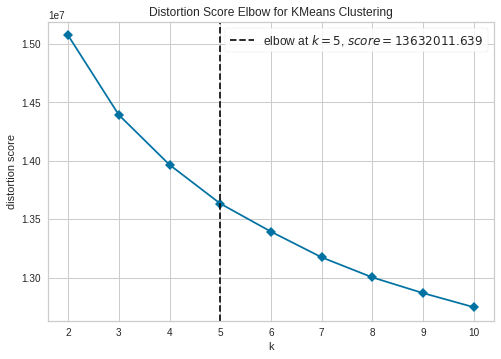

In [44]:

# Instantiate the clustering model and visualizer
km_customer = KMeans()
visualizer = KElbowVisualizer(
    km_customer, k=10, metric='distortion', timings=False
)

visualizer.fit(azdias_pca);        # Fit the data to the visualizer
visualizer.show();        # Finalize and render the figure

From the above graph it is clear that the point of maximum curvature corresponds to a cluster number of 6. Therefore we will produce a cluster of size 6 and analyse the resulting clusters. 

In [49]:
km_model = KMeans(n_clusters=5)

km_model.fit(azdias_pca)

KMeans(n_clusters=5)

In [50]:
customer_clusters = pd.Series(km_model.predict(pca_p1.fit_transform(customers_p1)))
azdias_clusters = pd.Series(km_model.predict(pca_p1.fit_transform(azdias_p1)))

In [51]:
cluster_data = pd.DataFrame({
    'Population': azdias_clusters.value_counts().sort_index(),
    'Customers': customer_clusters.value_counts().sort_index()
})

cluster_data.reset_index(inplace=True)
cluster_data.rename(columns={"index":"Cluster"}, inplace=True)
cluster_data

,Cluster,Population,Customers
0,0,135477,21705
1,1,154263,26301
2,2,164238,25316
3,3,144966,29598
4,4,138344,31326


Text(0.5, 0.98, 'Cluster Distributions')

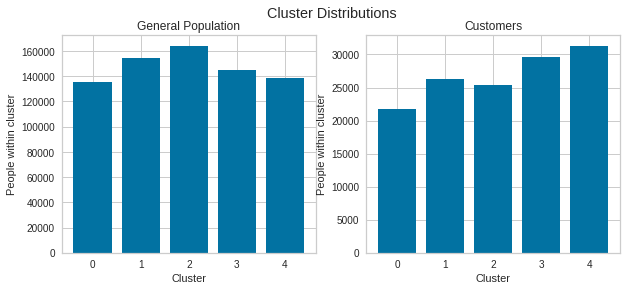

In [52]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 4))

ax1.bar(cluster_data["Cluster"], cluster_data["Population"])
ax1.set_xlabel("Cluster")
ax1.set_ylabel("People within cluster")
ax1.set_title("General Population")

ax2.bar(cluster_data["Cluster"], cluster_data["Customers"])
ax2.set_xlabel("Cluster")
ax2.set_ylabel("People within cluster")
ax2.set_title("Customers")

fig.suptitle("Cluster Distributions")

Lets see what the most which clusters have the largest proportion of customers to general population. This will be to shortlist the clusters which deserve the most attention

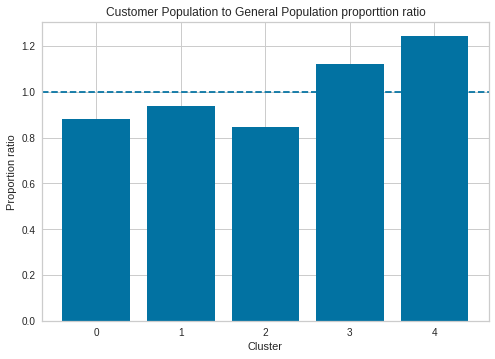

In [53]:
cluster_data['customer2pop_ratio'] = (cluster_data.Customers / cluster_data.Customers.sum())  / \
(cluster_data.Population / cluster_data.Population.sum())

plt.bar(cluster_data.Cluster,cluster_data.customer2pop_ratio)
plt.xlabel('Cluster')
plt.ylabel('Proportion ratio')
plt.title('Customer Population to General Population proportion ratio')
plt.axhline(y=1, linestyle = "--",)


All in all it looks like the proportion of customers are evenly distributed along each of the clusters. Therefore I don't think there's really much value in focusing more on any particular cluster.

* From this section we have learnt that most of the data can be dropped down to roughly 100 features and still attain a good idea of what the data is.
* The clusters all roughly have the same proportion of customers in them. This implies that the number of customers are evenly distributed along the general population at a macroscale.

### Need to find the most important features for each cluster

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [37]:
mailout_train = pd.read_csv('./Udacity_MAILOUT_052018_TRAIN.csv')

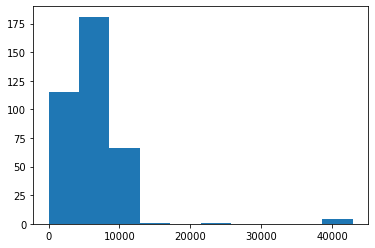

In [38]:
plt.hist(mailout_train.isna().sum(axis=0));

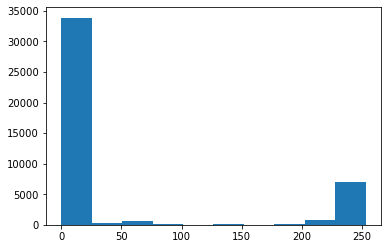

In [39]:
plt.hist(mailout_train.isna().sum(axis=1));

The best values look like around 50 for the rows and 15000 for the columns

In [41]:
mailout_train = clean_df('./Udacity_MAILOUT_052018_TRAIN.csv',50,15_000)

All the null values are removed

Lets check how balanced the dataset is

(array([0, 1]), [Text(0, 0, '0.0'), Text(1, 0, '1.0')])

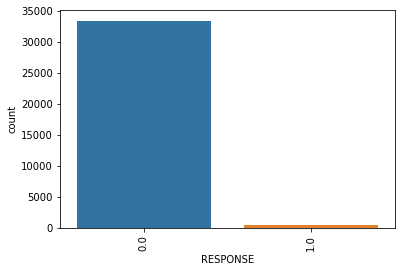

In [43]:
sns.countplot(mailout_train['RESPONSE'])
plt.xticks(rotation=90)

From the above it looks like the dataset needs to be rebalanced. So lets perfrom random oversampling to rebalance the dataset. For more information about what random oversampling is, click <a href=https://machinelearningmastery.com/random-oversampling-and-undersampling-for-imbalanced-classification/>here.</a>

In [44]:
def rand_oversamp(df,proportion=0.5,col='RESPONSE',val=1):
    """
    Returns a dataframe where a sample is randomly chosen from a column of a given value
    in the dataframe. The sample is then concatenated with the dataframe to produce a new dataframe 
    where the value is present in a predefined proportion.
    Input
    df: dataframe were random oversampling will be performed on.
    """
    resample_num = int((0.5 * len(mailout_train) - mailout_train[col].value_counts()[1]) / 0.5)
    to_sample = df[df[col] == val]
    resample2add = to_sample.sample(n=resample_num,replace=True)
    
    return pd.concat([df,resample2add])

In [45]:
mailout_train_rebalanced = rand_oversamp(mailout_train,proportion=0.5,val=1)

In [46]:
mailout_train_rebalanced.RESPONSE.value_counts()

0.0    33421
1.0    33421
Name: RESPONSE, dtype: int64

Now lets create the training and test sets

In [47]:
X_rebal = mailout_train_rebalanced.drop(columns=['RESPONSE'])
y_rebal = mailout_train_rebalanced['RESPONSE']

X_train_rebal, X_test_rebal, y_train_rebal, y_test_rebal = train_test_split(X_rebal,y_rebal,test_size=0.2)

Prior to doing any training lets do some feature reduction using scikit-learn's `Selectkbest` estimator. For this instance lets use all of the dataframe to determine what the best number of parameters are. And also since this isn't directly used for training but rather as a qualitivative assessment of what the best parameters are.

In [48]:
kbest_pipeline = Pipeline(steps=[
    ('scale',MinMaxScaler()),
    ('kbest',SelectKBest(chi2,k='all'))
])

kbest_pipeline.fit(X_rebal,y_rebal)

Pipeline(steps=[('scale', MinMaxScaler()),
                ('kbest',
                 SelectKBest(k='all',
                             score_func=<function chi2 at 0x7fade7cc9820>))])

In [49]:
kb_selector = kbest_pipeline['kbest']

Text(0, 0.5, 'Cumulative Chi squared score')

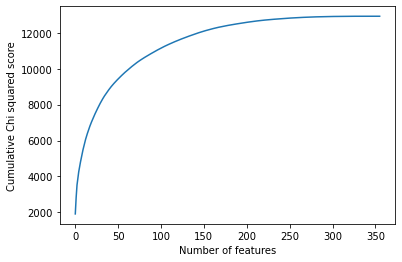

In [97]:
plt.plot(np.cumsum(np.sort(np.abs(kb_selector.scores_))[::-1]))
plt.xlabel('Number of features')
plt.ylabel('Cumulative Chi squared score')

In [51]:
idx = np.argsort(np.abs(kb_selector.scores_))[::-1][:15]
top_features = X_rebal.columns[idx]

In [58]:
d = []

for feature in top_features:
    if feature in attributes_info.Attribute.values:
        d.append(attributes_info[attributes_info['Attribute'] == feature]['Description'].values[0])
    else:
        d.append('No description')

In [59]:
d

['No description',
 'No description',
 'No description',
 'No description',
 'actuality of the last transaction for the segment banks ONLINE',
 'financial typology: unremarkable',
 'share of all-terrain vehicles and MUVs in the microcell',
 'No description',
 'No description',
 'No description',
 'share of cars with an engine power between 31 and 40 KW - PLZ8',
 'No description',
 'No description',
 'share of cars with max speed between 110 km/h and 140km/h within the PLZ8',
 'share of cars with Diesel-engine in the microcell']

In [60]:
def importance_report(df,kbest,n_features=10,attrib_info=attributes_info):
    """
    Returns a dataframe which summarises the features and their descriptions along with the score value.
    Input:
    df: Dataframe to perform supervised feature selection on (via SelectKBest).
    kbest: SelectKBest class which has already been fitted against the dataframe df.
    n_features: The top n_features will be presented in the output dataframe
    attrib_info: A dataframe which contains all the information about the column data and their
    descriptions.
    """
    #Plot curve for scores
    plt.plot(np.cumsum(np.sort(np.abs(kbest.scores_))[::-1]))
    #Get index to extract the column names and scores
    idx = np.argsort(np.abs(kb_selector.scores_))[::-1][:n_features]
    
    scores = []
    descriptions = []
    features = []
    
    for i in idx:
        scores.append(kbest.scores_[i])
        features.append(df.columns[i])
    
    for feature in features:
        if feature in attributes_info.Attribute.values:
            descriptions.append(attrib_info[attrib_info['Attribute'] == feature]['Description'].values[0])
        else:
            descriptions.append('No description')

    return pd.DataFrame({
        'Feature':features,
        'Description':descriptions,
        'Chi squared scores': scores
    })
    

In [61]:
X_rebal.columns

Index(['LNR', 'AKT_DAT_KL', 'ALTER_HH', 'ALTERSKATEGORIE_FEIN',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'ANZ_KINDER', 'ANZ_PERSONEN',
       'ANZ_STATISTISCHE_HAUSHALTE', 'ANZ_TITEL',
       ...
       'VHN', 'VK_DHT4A', 'VK_DISTANZ', 'VK_ZG11', 'W_KEIT_KIND_HH',
       'WOHNDAUER_2008', 'WOHNLAGE', 'ZABEOTYP', 'ANREDE_KZ',
       'ALTERSKATEGORIE_GROB'],
      dtype='object', length=356)

,Feature,Description,Chi squared scores
0,D19_LEBENSMITTEL,No description,1946.992379
1,D19_KOSMETIK,No description,962.417342
2,D19_TECHNIK,No description,705.224438
3,D19_BANKEN_LOKAL,No description,379.193835
4,D19_BANKEN_ONLINE_DATUM,actuality of the last transaction for the segment banks ONLINE,349.554239
5,FINANZ_UNAUFFAELLIGER,financial typology: unremarkable,271.696473
6,KBA05_SEG7,share of all-terrain vehicles and MUVs in the microcell,259.072331
7,RT_SCHNAEPPCHEN,No description,233.934946
8,ANZ_KINDER,No description,221.960551
9,D19_VERSAND_ANZ_12,No description,221.814301


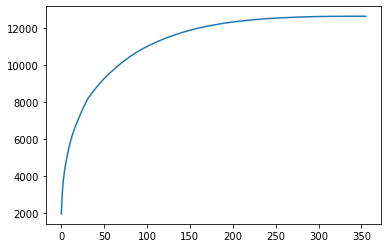

In [62]:
importance_report(X_rebal,kb_selector)

It looks like 150 components are sufficient for modelling the data. So we'll transform the data

In [54]:
kbest_pipeline_150  = Pipeline(steps=[
    ('scaler',MinMaxScaler()),
    ('kbest',SelectKBest(chi2,k=150))
])
kbest_pipeline_150.fit(X_rebal, y_rebal)

cols = kbest_pipeline_150['kbest'].get_support(indices=True)
X_rebal_kbest = X_rebal.iloc[:,cols]
X_rebal_kbest.head()

,LNR,AKT_DAT_KL,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_KINDER,ANZ_PERSONEN,CAMEO_INTL_2015,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,...,SHOPPER_TYP,STRUKTURTYP,VERDICHTUNGSRAUM,VERS_TYP,VHA,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,ZABEOTYP,ANREDE_KZ
0,21.0,4.0,11.0,1.0,1.0,8.0,0.0,2.0,5.0,2.0,...,3.0,3.0,4.0,2.0,1.0,2.0,1.0,6.000000,3.0,2.0
1,19.0,4.0,9.0,1.0,4.0,13.0,0.0,2.0,2.0,2.0,...,2.0,1.0,0.0,1.0,1.0,2.0,1.0,4.000000,1.0,2.0
2,8.0,1.0,2.0,0.0,1.0,9.0,0.0,4.0,5.0,1.0,...,3.0,3.0,10.0,1.0,4.0,4.0,2.0,4.608797,3.0,1.0
3,8.0,1.0,2.0,1.0,1.0,6.0,0.0,2.0,5.0,2.0,...,1.0,3.0,5.0,2.0,1.0,11.0,11.0,6.000000,3.0,2.0
4,31.0,6.0,13.0,1.0,1.0,9.0,0.0,6.0,5.0,1.0,...,1.0,3.0,4.0,1.0,0.0,2.0,1.0,6.000000,3.0,1.0


## Training the model

Lets split the data and then create a pipeline to train and another function to evaluate the model

In [55]:
X_trn, X_tst, y_trn, y_tst = train_test_split(X_rebal_kbest,y_rebal.astype('int'),test_size=0.2, random_state=0)

In [56]:
y_trn.value_counts()

0    26809
1    26664
Name: RESPONSE, dtype: int64

In [69]:
def create_pipeline(model):
    """Creates a pipeline for training a model. Only transformation is the MinMaxScaler. 
    This is a helper function for optimise_model"""
    return Pipeline(steps=[
    ('scaler',MinMaxScaler()),
    ('model',model)
])

def _train_gridcv(pipe,params,xtrain=X_trn,ytrain=y_trn):
    """Creates a gridsearchcv object which is trained using xtrain as the input data and ytrain as the label.
    Returns the gridsearchcv object. This is a helper function for optimise_model
    """
    
    g = GridSearchCV(pipe,param_grid=params,scoring=roc_auc_score)
    g.fit(xtrain,ytrain)
    print('The best estimator is:')
    print(g.best_params_)
    print('='*20)
    return g

def _evaluate(grid,xtest=X_tst,ytest=y_tst):
    """
    Evaluates the model based on the test set. This is a helper function for optimise_model
    """

    model = grid.best_estimator_
    preds = model.predict(xtest)
    return roc_auc_score(preds,ytest)

def optimise_model(pipe,params,xtrain=X_trn,xtest=X_tst,ytrain=y_trn,ytest=y_tst):
    """
    Takes in a pipeline and creates a gridsearchcv object which is used to determine the optimal set
    of parameters defined by the 'params' parameter.
    """
    
    trained_grid = _train_gridcv(pipe,params)
    
    final_score = _evaluate(trained_grid)
    
    print('Final score:',final_score)
    return trained_grid

def model_scorer(model,xtrain=X_trn,xtest=X_tst,ytrain=y_trn,ytest=y_tst):
    """
    Trains a model and returns the score
    """
    model_pipe = create_pipeline(model)
    model_pipe.fit(xtrain,ytrain)
    preds = model_pipe.predict(xtest)
    score = roc_auc_score(preds,ytest)
    return score
    

In [81]:
models = [("LogisticRegression", LogisticRegression()),
          ('KNearestNeighbour',KNeighborsClassifier()),
          ('GaussianNB', GaussianNB()),
          ("XGBClassifier",XGBRFClassifier())]

In [83]:
model_results = {
    'Model':[],
    'Score':[]
}

for name,model in models:
    model_results['Model'].append(name)
    model_results['Score'].append(model_scorer(model))

pd.DataFrame(model_results)

[20:31:56] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


,Model,Score
0,LogisticRegression,0.741304
1,RandomForestClassifier,1.000000
2,KNearestNeighbour,0.973577
3,GaussianNB,0.683188
4,XGBClassifier,0.858027


### K nearest neighbours

In [67]:
knn_pipe = create_pipeline(KNeighborsClassifier())
knn_param_grid = {
    'model__n_neighbors': [1,2,3,4,6,8,10],
    'model__weights': ['uniform','distance']
}

knn_trained_grid = optimise_model(knn_pipe,knn_param_grid)

The best estimator is:
{'model__n_neighbors': 1, 'model__weights': 'uniform'}
Final score: 0.990134919483534


In [71]:
%%time
knn_trained_grid.predict(X_rebal_kbest);


CPU times: user 6min 38s, sys: 6.16 s, total: 6min 44s
Wall time: 6min 44s


array([0, 0, 0, ..., 1, 1, 1])

Unfortunately with 150 features it is unfeasible to use permutation feature importance to determine the most importance features for the k nearest neighbour algorithm.

### Logistic regression

In [69]:
logreg_pipe = create_pipeline(LogisticRegression(max_iter=500,solver='saga',tol=0.01))
logreg_param_grid = {
    'model__warm_start': [True, False]
}

logreg_trained_grid = optimise_model(logreg_pipe,logreg_param_grid)

The best estimator is:
{'model__warm_start': True}
Final score: 0.747456241744437


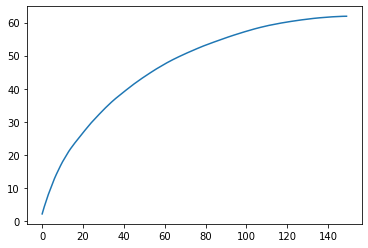

In [128]:
logreg_best_model = logreg_trained_grid.best_estimator_['model']
plt.plot(np.cumsum(np.sort(np.abs(logreg_best_model.coef_[0]))[::-1]))

In [125]:
def logreg_important_features(grid,df=X_rebal_kbest,n_features=10,attrib_info=attributes_info):
    """
    Returns a dataframe which summarises the features and their descriptions along with the most important
    features based on the coefficients of the logistic regression.
    Input:
    df: Dataframe to perform supervised feature selection on (via SelectKBest).
    grid: gridsearchcv class which has already been fitted against the dataframe df using logistic regression.
    n_features: The top n_features will be presented in the output dataframe
    attrib_info: A dataframe which contains all the information about the column data and their
    descriptions.
    """
    logreg_model = grid.best_estimator_['model']
    idx = np.argsort(np.abs(logreg_model.coef_[0]))[::-1][:n_features]
    
    scores = []
    descriptions = []
    features = []
    
    for i in idx:
        scores.append(logreg_model.coef_[0][i])
        features.append(df.columns[i])
    
    for feature in features:
        if feature in attributes_info.Attribute.values:
            descriptions.append(attrib_info[attrib_info['Attribute'] == feature]['Description'].values[0])
        else:
            descriptions.append('No description')

    return pd.DataFrame({
        'Features':features,
        'Description':descriptions,
        'Feature_weight': scores
    })

In [134]:
logreg_important_features(logreg_trained_grid)

,Features,Description,Feature_weight
0,D19_TECHNIK,No description,-2.151738
1,D19_TELKO_ANZ_24,No description,-2.109638
2,D19_BANKEN_ONLINE_DATUM,actuality of the last transaction for the segment banks ONLINE,-1.902042
3,MIN_GEBAEUDEJAHR,year the building was first mentioned in our database,-1.833519
4,D19_LEBENSMITTEL,No description,-1.615438
5,D19_KOSMETIK,No description,-1.602815
6,LP_STATUS_GROB,social status rough,1.591954
7,KBA13_HALTER_20,share of car owners below 21 within the PLZ8,1.383325
8,PLZ8_GBZ,number of buildings within the PLZ8,-1.293400
9,D19_TELKO_DATUM,actuality of the last transaction for the segment telecommunication TOTAL,1.265071


### Naive bayes

### XGBoosted learning

In [70]:
%%time
xgb_pipe = create_pipeline(XGBRFClassifier(verbosity = 0,random_state=0))

xgb_params = {"model__max_depth": [15],
              "model__learning_rate": [0.05,0.1],
              "model__gamma":[1.5],
              "model__n_estimators":[350],
              }
xgb_trained_grid = optimise_model(xgb_pipe,xgb_params)

The best estimator is:
{'model__gamma': 1.5, 'model__learning_rate': 0.05, 'model__max_depth': 15, 'model__n_estimators': 350}
Final score: 0.9511885683760684
CPU times: user 51min 36s, sys: 3.22 s, total: 51min 39s
Wall time: 3min 18s


In [140]:
xgb_pipe = create_pipeline(XGBRFClassifier(verbosity = 0,random_state=0))

xgb_params = {"model__max_depth": [5,10,15],
              "model__learning_rate": [0.001,0.01,0.05],
              "model__gamma":[0.5,1.0,1.5],
              "model__n_estimators":[100,200,300],
              }
xgb_trained_grid = optimise_model(xgb_pipe,xgb_params)

The best estimator is:
{'model__gamma': 0.5, 'model__learning_rate': 0.001, 'model__max_depth': 15, 'model__n_estimators': 200}
Final score: 0.9531857813547955


The best score by far was obtained through xgboost.

In [146]:
def xgb_important_features(grid,df=X_rebal_kbest,n_features=5,attrib_info=attributes_info):
    """
    Returns a dataframe which summarises the features and their descriptions along with the score value
    based on a fitted xgboost classifier.
    Input:
    df: Dataframe to perform supervised feature selection on (via SelectKBest).
    grid: A gridsearchcv class which has already been fitted against the dataframe df using xgboost.
    n_features: The top n_features will be presented in the output dataframe
    attrib_info: A dataframe which contains all the information about the column data and their
    descriptions.
    """
    xgb_model = grid.best_estimator_['model']
    idx = np.argsort(np.abs(xgb_model.feature_importances_))[::-1][:n_features]
    
    scores = []
    descriptions = []
    features = []
    
    for i in idx:
        scores.append(xgb_model.feature_importances_[i])
        features.append(df.columns[i])
    
    for feature in features:
        if feature in attributes_info.Attribute.values:
            descriptions.append(attrib_info[attrib_info['Attribute'] == feature]['Description'].values[0])
        else:
            descriptions.append('No description')

    return pd.DataFrame({
        'Features':features,
        'Description':descriptions,
        'Feature_weight': scores
    })

In [147]:
xgb_important_features(xgb_trained_grid)

,Features,Description,Feature_weight
0,D19_TECHNIK,No description,0.195991
1,D19_LEBENSMITTEL,No description,0.048152
2,D19_KOSMETIK,No description,0.019213
3,LP_FAMILIE_FEIN,family type fine,0.008948
4,W_KEIT_KIND_HH,likelihood of a child present in this household (can be specified in child age groups),0.008810


It looks like the most important feature by far is `D19_TECHNIK` which is similar to the results with logistic regression however the results for xgboost is far more exaggerated.

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter.

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [84]:
mailout_test = pd.read_csv('Udacity_MAILOUT_052018_TEST.csv',)

In [85]:
mailout_test_LNR = mailout_test['LNR']

In [87]:
mailout_test = clean_df('Udacity_MAILOUT_052018_TEST.csv',0,0,drop=False)

In [92]:
knn = create_pipeline(KNeighborsClassifier(n_neighbors=1,weights='uniform'))
knn.fit(X_rebal_kbest,y_rebal)
preds_knn = knn.predict_proba(mailout_test[X_rebal_kbest.columns])[:,1]

kaggle_knn = pd.DataFrame(index=mailout_test_LNR,data=preds_knn)
kaggle_knn.rename(columns={0: "RESPONSE"}, inplace=True)

In [94]:
kaggle_knn.head()

,RESPONSE
LNR,
1754,0.0
1770,0.0
1465,0.0
1470,0.0
1478,0.0


In [96]:
kaggle_knn.shape

(42833, 1)

Data is the correct shape

In [95]:
kaggle_knn.to_csv('arvato_submission.csv')

# References

* https://www.scikit-yb.org/en/latest/api/cluster/elbow.html: fOR PLOTTING THE CURVE FOR KMEANS
* https://machinelearningmastery.com/random-oversampling-and-undersampling-for-imbalanced-classification/: For random oversampling
* https://machinelearningmastery.com/calculate-feature-importance-with-python/: For feature importance